In [ ]:
import sys

sys.append('/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging

from collections import Counter

from imblearn.datasets import fetch_datasets

from Evaluation import synthsonic

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import smote_variants as sv

ModuleNotFoundError: No module named 'Evaluation'

In [ ]:
# metrics 
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (recall_score, roc_auc_score, confusion_matrix, precision_score,
                             f1_score, balanced_accuracy_score, accuracy_score)

In [ ]:
_logger = logging.getLogger('smote_variants')
_logger.setLevel(logging.DEBUG)
_logger_ch = logging.StreamHandler()
_logger_ch.setFormatter(logging.Formatter(
    "%(asctime)s:%(levelname)s:%(message)s"))
_logger.addHandler(_logger_ch)

In [4]:
random_state = 5

# data checks

In [5]:
# loading imblearn Ecoli dataset

data = fetch_datasets()['ecoli']

X,y, name = data['data'], data['target'], data['DESCR']

In [6]:
def pca_plot(X,y) :
    
    x = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    
    fig = plt.figure(figsize = (12,7))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f'2 component PCA')

    counter = Counter(y)

    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        ax.scatter(principalComponents[rowix, 0], principalComponents[rowix, 1], label=str(label))

    ax.legend()

    fig.show()
    print(counter)

Counter({-1: 301, 1: 35})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


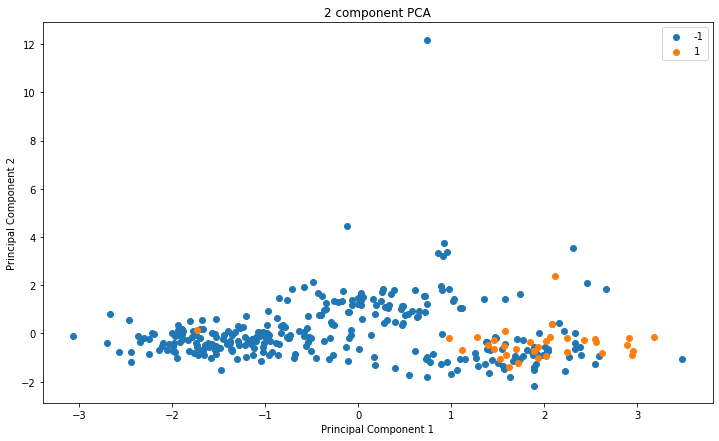

In [7]:
pca_plot(X,y)

In [8]:
for i in range(X.shape[1]) :
    print(i, len(np.unique(X[:,i])))

0 78
1 63
2 2
3 2
4 59
5 82
6 77


# Evaluation - base scenario

In [9]:
def test_metrics(training, testing, y_training, y_testing,title) :
    
    clf.fit(training,y_training)
    prediction = clf.predict(testing)
    proba = clf.predict_proba(testing)[:,1]

    f_dict = {
        'title': title,
        'accuracy': accuracy_score(y_testing, prediction),
        'balanced acc': balanced_accuracy_score(y_testing,prediction),
        'precision': precision_score(y_testing,prediction),
        'recall': recall_score(y_testing,prediction),
        'roc_auc_score': roc_auc_score(y_testing, proba),
        'f1_score': f1_score(y_testing, prediction, average='binary'),
        'geometric mean': geometric_mean_score(y_testing, prediction)
    }

    return f_dict

In [10]:
# base case
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)

In [11]:
X_train.shape, X_test.shape

((225, 7), (111, 7))

In [12]:
clf = DecisionTreeClassifier(random_state=random_state)

cv_result = cross_validate(clf, X_train, y_train, scoring=["balanced_accuracy","roc_auc_ovr_weighted","recall"])

cv_result

{'fit_time': array([0.00138092, 0.00081897, 0.00077987, 0.00069904, 0.00062895]),
 'score_time': array([0.00235701, 0.00208998, 0.00194407, 0.00177693, 0.00170588]),
 'test_balanced_accuracy': array([0.775     , 0.78205128, 0.80769231, 0.61538462, 0.65384615]),
 'test_roc_auc_ovr_weighted': array([0.775     , 0.78205128, 0.80769231, 0.61538462, 0.65384615]),
 'test_recall': array([0.6       , 0.66666667, 0.66666667, 0.33333333, 0.33333333])}

In [13]:
res_standard = test_metrics(X_train,X_test,y_train,y_test,"No SMOTE")
res_standard

{'title': 'No SMOTE',
 'accuracy': 0.9009009009009009,
 'balanced acc': 0.7904761904761904,
 'precision': 0.3076923076923077,
 'recall': 0.6666666666666666,
 'roc_auc_score': 0.7904761904761904,
 'f1_score': 0.42105263157894735,
 'geometric mean': 0.7807200583588265}

In [14]:
clf.fit(X_train,y_train)

prediction = clf.predict(X_test)

confusion_matrix(y_test,prediction)

array([[96,  9],
       [ 2,  4]])

In [15]:
results = pd.DataFrame(res_standard, index=[0])
results

,title,accuracy,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean
0,No SMOTE,0.900901,0.790476,0.307692,0.666667,0.790476,0.421053,0.78072


In [16]:
kneighbours = KNeighborsClassifier(3)
kneighbours.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
prediction = kneighbours.predict(X_test)
proba = kneighbours.predict_proba(X_test)[:,1]

f_dict = {
    'title': "K neighbours",
    'accuracy': accuracy_score(y_test, prediction),
    'balanced acc': balanced_accuracy_score(y_test,prediction),
    'precision': precision_score(y_test,prediction),
    'recall': recall_score(y_test,prediction),
    'roc_auc_score': roc_auc_score(y_test, proba),
    'f1_score': f1_score(y_test, prediction, average='binary'),
    'geometric mean': geometric_mean_score(y_test, prediction)
}
f_dict

{'title': 'K neighbours',
 'accuracy': 0.9459459459459459,
 'balanced acc': 0.8928571428571428,
 'precision': 0.5,
 'recall': 0.8333333333333334,
 'roc_auc_score': 0.9611111111111111,
 'f1_score': 0.625,
 'geometric mean': 0.8908708063747479}

# Evulation - SMOTE

In [18]:
# generate samples with different proportions
proportions = [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

samples_smote = []

for prop in proportions :
    o = sv.SMOTE(proportion = prop,
                   random_state = random_state)
    
    print(prop)
    x_g, y_g = o.sample(X_train,y_train)
    
    f_dict = {
        'prop':prop,
        'x_sample':x_g,
        'y_sample':y_g
    }
    
    samples_smote.append(f_dict)

2021-06-07 16:42:31,830:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:31,830:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:31,830:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.1, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:31,834:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.25, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:31,834:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.25, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:31,834:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.25, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:31,837:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 5}")
2021-06-07 16:42:

0.1
0.25
0.5
0.75
1.0
1.5
2.0


Counter({-1: 196, 1: 70})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 0.25 oversample)')

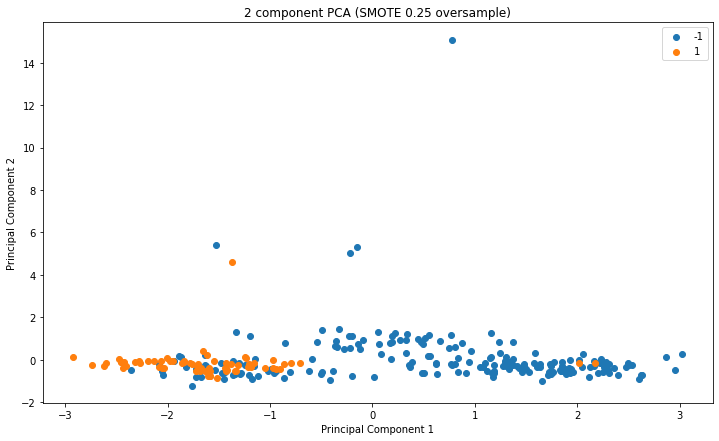

In [19]:
# 0.25
X,y = samples_smote[1]['x_sample'],samples_smote[1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 0.25 oversample)")

Counter({-1: 196, 1: 154})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 0.75 oversample)')

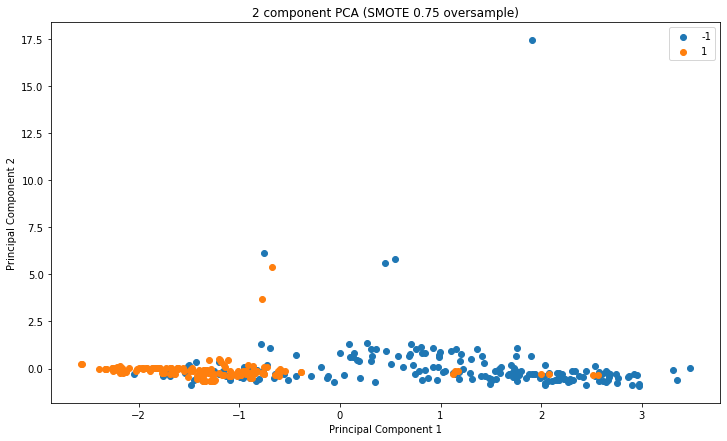

In [20]:
# 0.75
X,y = samples_smote[3]['x_sample'],samples_smote[3]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 0.75 oversample)")

Counter({-1: 196, 1: 196})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 1 oversample)')

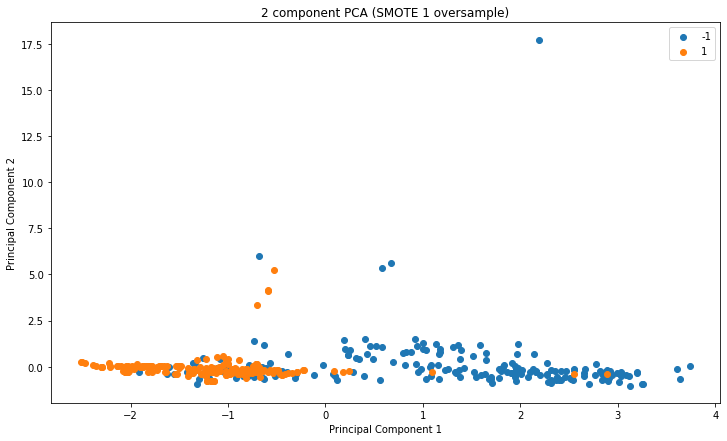

In [21]:
# 1
X,y = samples_smote[4]['x_sample'],samples_smote[4]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 1 oversample)")

Counter({1: 363, -1: 196})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (SMOTE 2x oversample)')

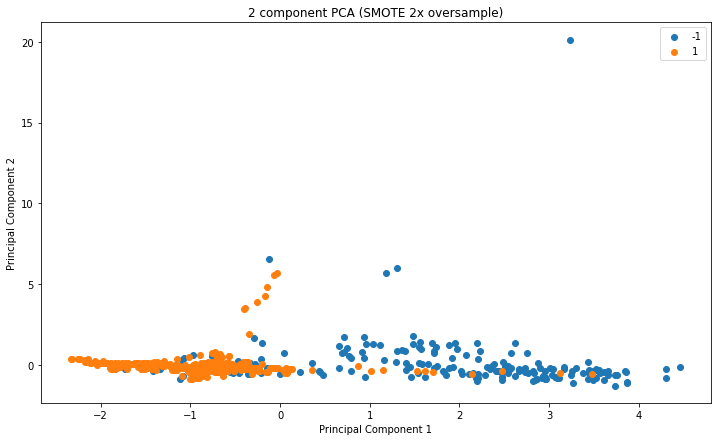

In [22]:
# 2
X,y = samples_smote[-1]['x_sample'],samples_smote[-1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (SMOTE 2x oversample)")

In [23]:
# Check metrics
X,y = samples_smote[2]['x_sample'],samples_smote[2]['y_sample']
res_025 = test_metrics(X, X_test, y, y_test, "SMOTE oversampling 0.25")

results = results.append(res_025, ignore_index=True)
results

,title,accuracy,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean
0,No SMOTE,0.900901,0.790476,0.307692,0.666667,0.790476,0.421053,0.78072
1,SMOTE oversampling 0.25,0.891892,0.628571,0.200000,0.333333,0.628571,0.250000,0.55492


In [24]:
clf.fit(X,y)
prediction = clf.predict(X_test)
confusion_matrix(y_test,prediction)

array([[97,  8],
       [ 4,  2]])

In [25]:
# Check metrics
X,y = samples_smote[4]['x_sample'],samples_smote[4]['y_sample']
res_075 = test_metrics(X, X_test, y, y_test, "SMOTE oversampling 0.75")

results = results.append(res_075, ignore_index=True)
results

,title,accuracy,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean
0,No SMOTE,0.900901,0.790476,0.307692,0.666667,0.790476,0.421053,0.780720
1,SMOTE oversampling 0.25,0.891892,0.628571,0.200000,0.333333,0.628571,0.250000,0.554920
2,SMOTE oversampling 0.75,0.864865,0.614286,0.153846,0.333333,0.614286,0.210526,0.546272


In [26]:
clf.fit(X,y)
prediction = clf.predict(X_test)
confusion_matrix(y_test,prediction)

array([[94, 11],
       [ 4,  2]])

# Evaluate synthsonic 

In [27]:
samples_synth = []

for prop in proportions :
    o = synthsonic(distinct_threshold=3,
                   proportion = prop,
                   random_state = random_state)
    
    print(prop)
    x_g, y_g = o.sample(X_train,y_train)
    
    f_dict = {
        'prop':prop,
        'x_sample':x_g,
        'y_sample':y_g
    }
    
    samples_synth.append(f_dict)

2021-06-07 16:42:32,621:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': 3, 'random_state': RandomState(MT19937) at 0x7F83E7164490}")
2021-06-07 16:42:32,621:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': 3, 'random_state': RandomState(MT19937) at 0x7F83E7164490}")
2021-06-07 16:42:32,621:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 0.1, 'n_jobs': 1, 'distinct_threshold': 3, 'random_state': RandomState(MT19937) at 0x7F83E7164490}")
n_quantiles (500) is greater than the total number of samples (29). n_quantiles is set to num samples.


0.1
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 2188.56it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

0.25
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 2871.37it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

0.5
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 2460.58it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

0.75
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 2339.35it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

1.0
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 1890.86it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

1.5
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 2431.86it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

2.0
minority class 1, min dataset (29, 7)


Building tree: 100%|██████████| 15/15.0 [00:00<00:00, 1312.66it/s]
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  "Found unknown state name. Trying to switch to using all state names as state numbers"
Generating for node: 3: 100%|██████████| 7/7 [00:01<00:00,  5.86it/s]
/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/sklearn/isotonic.py:71: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
Generating for node: 0:   0%|          | 0/7 [00:00<?, ?it/s]/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:522: UserWarning: Found unknown state name. Trying to switch to using all state n

Counter({-1: 196, 1: 70})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (Synthsonic 0.25 oversample)')

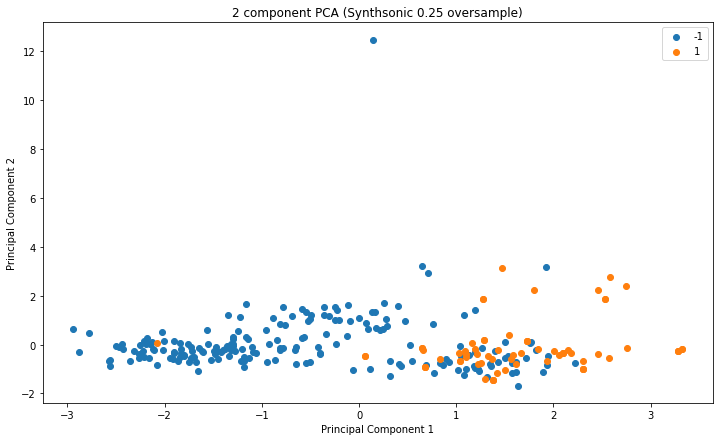

In [28]:
# 0.25

X,y = samples_synth[1]['x_sample'],samples_synth[1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (Synthsonic 0.25 oversample)")

Counter({-1: 196, 1: 196})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (Synthsonic 1 oversample)')

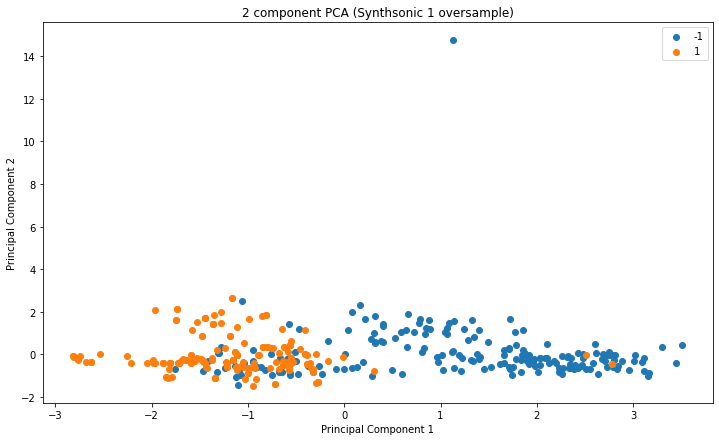

In [29]:
# 1

X,y = samples_synth[4]['x_sample'],samples_synth[4]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (Synthsonic 1 oversample)")

Counter({1: 363, -1: 196})


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 1.0, '2 component PCA (Synthsonic x2 oversample)')

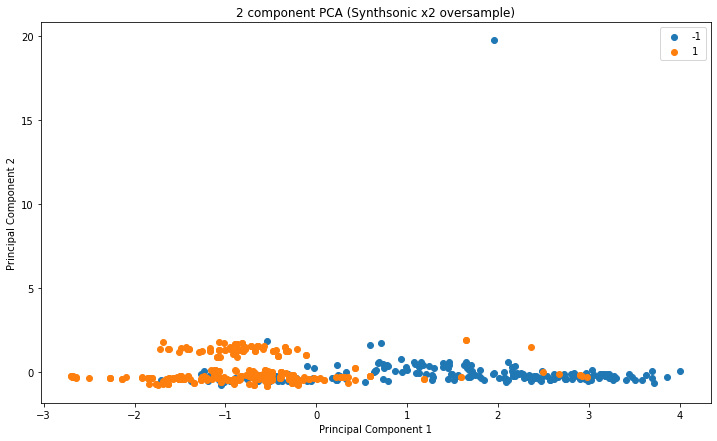

In [30]:
# 2

X,y = samples_synth[-1]['x_sample'],samples_synth[-1]['y_sample']

pca_plot(X,y)
plt.title("2 component PCA (Synthsonic x2 oversample)")

In [31]:
X,y = samples_synth[2]['x_sample'],samples_synth[2]['y_sample']
res_025 = test_metrics(X, X_test, y, y_test, "Synthsonic oversampling 0.25")

results = results.append(res_025, ignore_index=True)
results

,title,accuracy,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean
0,No SMOTE,0.900901,0.790476,0.307692,0.666667,0.790476,0.421053,0.780720
1,SMOTE oversampling 0.25,0.891892,0.628571,0.200000,0.333333,0.628571,0.250000,0.554920
2,SMOTE oversampling 0.75,0.864865,0.614286,0.153846,0.333333,0.614286,0.210526,0.546272
3,Synthsonic oversampling 0.25,0.927928,0.804762,0.400000,0.666667,0.804762,0.500000,0.792825


In [32]:
X,y = samples_synth[4]['x_sample'],samples_synth[4]['y_sample']
res_1 = test_metrics(X, X_test, y, y_test, "Synthsonic oversampling 1")

results = results.append(res_1, ignore_index=True)
results

,title,accuracy,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean
0,No SMOTE,0.900901,0.790476,0.307692,0.666667,0.790476,0.421053,0.780720
1,SMOTE oversampling 0.25,0.891892,0.628571,0.200000,0.333333,0.628571,0.250000,0.554920
2,SMOTE oversampling 0.75,0.864865,0.614286,0.153846,0.333333,0.614286,0.210526,0.546272
3,Synthsonic oversampling 0.25,0.927928,0.804762,0.400000,0.666667,0.804762,0.500000,0.792825
4,Synthsonic oversampling 1,0.927928,0.726190,0.375000,0.500000,0.726190,0.428571,0.690066


In [33]:
X,y = samples_synth[6]['x_sample'],samples_synth[6]['y_sample']
res_2 = test_metrics(X, X_test, y, y_test, "Synthsonic oversampling 2")

results = results.append(res_2, ignore_index=True)
results

,title,accuracy,balanced acc,precision,recall,roc_auc_score,f1_score,geometric mean
0,No SMOTE,0.900901,0.790476,0.307692,0.666667,0.790476,0.421053,0.780720
1,SMOTE oversampling 0.25,0.891892,0.628571,0.200000,0.333333,0.628571,0.250000,0.554920
2,SMOTE oversampling 0.75,0.864865,0.614286,0.153846,0.333333,0.614286,0.210526,0.546272
3,Synthsonic oversampling 0.25,0.927928,0.804762,0.400000,0.666667,0.804762,0.500000,0.792825
4,Synthsonic oversampling 1,0.927928,0.726190,0.375000,0.500000,0.726190,0.428571,0.690066
5,Synthsonic oversampling 2,0.927928,0.961905,0.428571,1.000000,0.961905,0.600000,0.961150
